# [**Comparaison de la régression à noyau et de la régression des processus gaussiens**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_7_gaussian_process/plot_compare_gpr_krr.ipynb)<br/>([_Comparison of kernel ridge and Gaussian process regression_](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html))

Cet exemple illustre les différences entre une régression à noyau et une régression des processus gaussiens.

La régression à noyau et la régression des processus gaussiens utilisent toutes deux une "astuce de noyau" pour rendre leurs modèles suffisamment expressifs pour s'adapter aux données d'entraînement. Cependant, les problèmes d'apprentissage automatique résolus par les deux méthodes sont radicalement différents.

La régression à noyau trouvera la fonction cible qui minimise une fonction de perte (l'erreur quadratique moyenne).

Au lieu de trouver une seule fonction cible, la régression des processus gaussiens adopte une approche probabiliste : une distribution gaussienne a posteriori des fonctions cibles est définie en utilisant le théorème de Bayes. Ainsi, les probabilités a priori des fonctions cibles sont combinées avec une fonction de vraisemblance définie par les données d'entraînement observées pour fournir des estimations des distributions a posteriori.

Nous illustrerons ces différences avec un exemple et nous nous concentrerons également sur l'ajustement des hyperparamètres du noyau.

In [ ]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

# Génération d'un ensemble de données

Nous créons un ensemble de données synthétiques. Le véritable processus génératif prendra un vecteur à une seule dimension et calculera son sinus. Notez que la période de ce sinus est donc de $2\pi$. Nous réutiliserons cette information plus tard dans cet exemple.

In [1]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

Maintenant, nous pouvons imaginer un scénario où nous obtenons des observations à partir de ce processus réel. Cependant, nous ajouterons quelques défis :
- les mesures seront bruyantes ;
- seuls les échantillons du début du signal seront disponibles.

In [2]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

Montrons le signal réel et les mesures bruyantes disponibles pour l'entraînement.

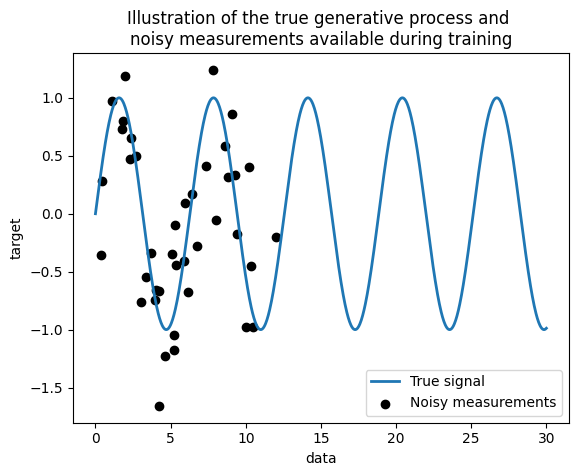

In [3]:
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

# Limitations d'un modèle linéaire simple

Tout d'abord, nous aimerions mettre en évidence les limites d'un modèle linéaire étant donné notre ensemble de données. Nous ajustons un modèle Ridge et vérifions les prédictions de ce modèle sur notre ensemble de données.

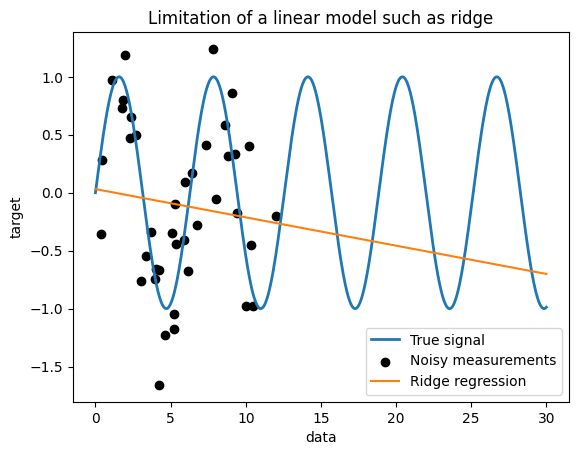

In [4]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

Un tel régresseur Ridge sous-ajuste les données car il n'est pas suffisamment expressif.

# Méthodes de noyau : régression à noyau et régression des processus gaussiens

## Régression à noyau

Nous pouvons rendre le modèle linéaire précédent plus expressif en utilisant un "noyau" appelé noyau. Un noyau est une mise en correspondance de l'espace des caractéristiques d'origine vers un autre. En termes simples, il est utilisé pour mapper nos données d'origine dans un espace de caractéristiques plus récent et plus complexe. Cet espace est défini explicitement par le choix du noyau.

Dans notre cas, nous savons que le véritable processus génératif est une fonction périodique. Nous pouvons utiliser un noyau [**`ExpSineSquared`**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared) qui permet de récupérer la périodicité. La classe [**`KernelRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge) acceptera un tel noyau.

L'utilisation de ce modèle associé à un noyau équivaut à intégrer les données en utilisant la fonction de mise en correspondance du noyau, puis à appliquer une régression Ridge. En pratique, les données ne sont pas mappées explicitement ; à la place, le produit scalaire entre les échantillons dans l'espace des caractéristiques de dimension supérieure est calculé à l'aide de l' "astuce du noyau".

Ainsi, utilisons un [**`KernelRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge) de ce type.

In [5]:
import time

from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

start_time = time.time()
kernel_ridge.fit(training_data, training_noisy_target)
print(
    f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds"
)

Fitting KernelRidge with default kernel: 0.036 seconds


Ce modèle ajusté n'est pas précis. En effet, nous n'avons pas défini les paramètres du noyau et avons plutôt utilisé les valeurs par défaut. Nous pouvons les inspecter.

In [6]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

Notre noyau a deux paramètres : l'échelle de longueur et la périodicité. Pour notre ensemble de données, nous utilisons `sin` comme processus génératif, ce qui implique une périodicité de $2\pi$ pour le signal. La valeur par défaut du paramètre étant de $1$, cela explique la haute fréquence observée dans les prédictions de notre modèle. Des conclusions similaires pourraient être tirées avec le paramètre d'échelle de longueur. Ainsi, cela nous indique que les paramètres du noyau doivent être ajustés. Nous utiliserons une recherche aléatoire pour régler les différents paramètres du modèle de régression du noyau : le paramètre `alpha` et les paramètres du noyau.

In [7]:
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 6.002 seconds


Ajuster le modèle est maintenant plus coûteux en termes de calcul, car nous devons essayer plusieurs combinaisons d'hyperparamètres. Nous pouvons jeter un coup d'œil aux hyperparamètres trouvés pour avoir une idée.

In [8]:
kernel_ridge_tuned.best_params_

{'alpha': 1.9915849773450223,
 'kernel__length_scale': 0.7986499491396728,
 'kernel__periodicity': 6.607275806426108}

En examinant les meilleurs paramètres, nous voyons qu'ils sont différents des valeurs par défaut. Nous constatons également que la périodicité est plus proche de la valeur théorique attendue, $2\pi$. Nous pouvons maintenant inspecter les prédictions de notre régression de noyau ajustée.

In [9]:
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(data)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.004 seconds


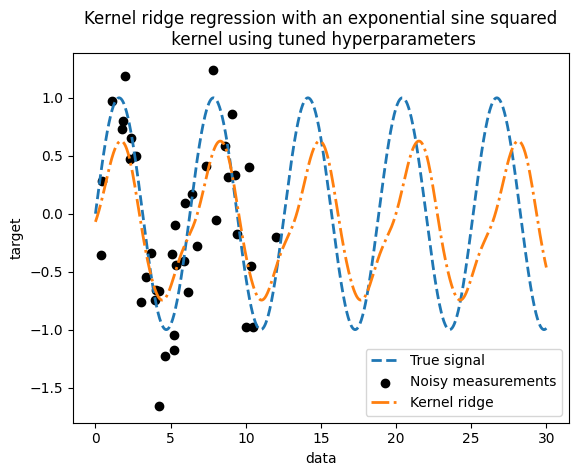

In [10]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)

Nous obtenons un modèle beaucoup plus précis. Nous observons toujours quelques erreurs principalement dues au bruit ajouté à l'ensemble de données.

## Régression des processus gaussiens

Maintenant, nous allons utiliser un [**`GaussianProcessRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) pour ajuster le même ensemble de données. Lors de l'entraînement d'un processus gaussien, les hyperparamètres du noyau sont optimisés lors du processus d'ajustement. Il n'est pas nécessaire de faire une recherche externe d'hyperparamètres. Ici, nous créons un noyau légèrement plus complexe que pour le régresseur à noyau : nous ajoutons un [**`WhiteKernel`**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html#sklearn.gaussian_process.kernels.WhiteKernel) qui est utilisé pour estimer le bruit dans l'ensemble de données.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
    1e-1
)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(training_data, training_noisy_target)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor fitting: 0.060 seconds


Le coût de calcul de l'entraînement d'un processus gaussien est bien inférieur à celui de la régression du noyau qui utilise une recherche aléatoire. Nous pouvons vérifier les paramètres des noyaux que nous avons calculés.

In [12]:
gaussian_process.kernel_

0.675**2 * ExpSineSquared(length_scale=1.34, periodicity=6.57) + WhiteKernel(noise_level=0.182)

En effet, nous constatons que les paramètres ont été optimisés. En examinant le paramètre `periodicity`, nous voyons que nous avons trouvé une période proche de la valeur théorique de $2\pi$. Nous pouvons maintenant jeter un coup d'œil aux prédictions de notre modèle.

In [13]:
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)
print(
    f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor predict: 0.003 seconds


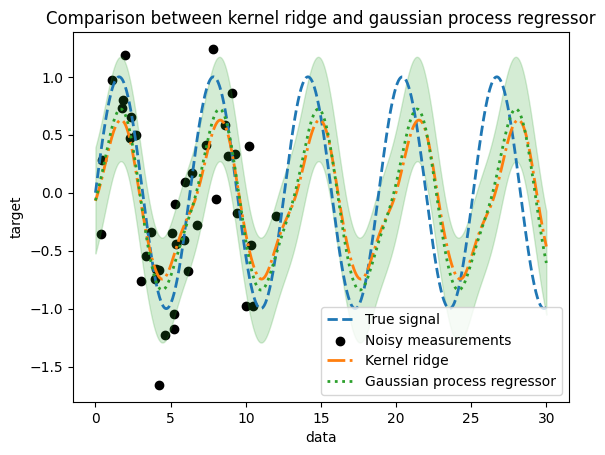

In [14]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")

Nous constatons que les résultats de la régression du noyau et du régresseur des processus gaussiens sont similaires. Cependant, le régresseur des processus gaussiens fournit également des informations sur l'incertitude qui ne sont pas disponibles avec un régresseur à noyau. En raison de la formulation probabiliste des fonctions cibles, le processus gaussien peut produire l'écart type (ou la covariance) avec les prédictions moyennes des fonctions cibles.

Cependant, cela a un coût : le temps nécessaire pour calculer les prédictions est plus élevé avec un processus gaussien.

# Conclusion finale

Nous pouvons donner un dernier mot sur la possibilité pour les deux modèles d'extrapoler. En effet, nous n'avons fourni que le début du signal comme ensemble d'entraînement. En utilisant un noyau périodique, notre modèle est contraint de répéter le motif trouvé sur l'ensemble d'entraînement. En utilisant cette information sur le noyau associée à la capacité des deux modèles à extrapoler, nous constatons que les modèles continueront à prédire le motif sinusoïdal.

Le processus gaussien permet de combiner des noyaux. Ainsi, nous pourrions associer le noyau carré au noyau à base radiale.

In [ ]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed"
) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_data, training_noisy_target)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)

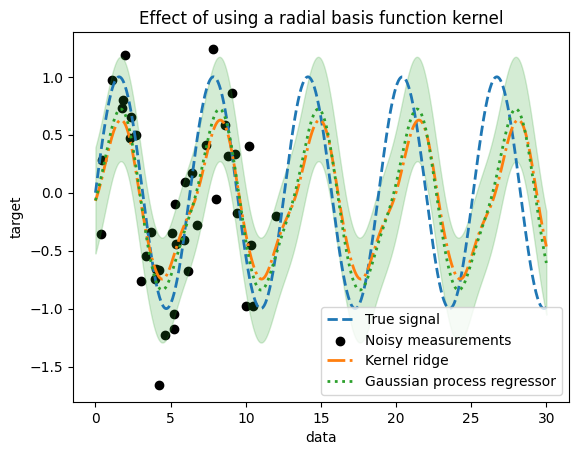

: 

In [15]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Effect of using a radial basis function kernel")

L'effet de l'utilisation d'un noyau à base radiale atténuera l'effet de périodicité une fois que l'ensemble d'entraînement ne sera plus disponible. À mesure que les échantillons de test s'éloignent des échantillons d'entraînement, les prédictions convergent vers leur moyenne et leur écart type augmente également.